In [1]:
# Basic
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

import tensorflow_datasets as tfds


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:

sns.set_style('darkgrid')

In [4]:

dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)
train_dataset = dataset['train']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.Q1FC3E_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


**Dataprep**

In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
image_size = 128
batch_size = 32

# Load dataset
dataset, info = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True)
full_dataset = dataset['train']

# Shuffle and split (80-20)
total_samples = info.splits['train'].num_examples
train_size = int(0.8 * total_samples)

full_dataset = full_dataset.shuffle(1000, seed=42)
train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size)

# Resize and normalize on the fly
def preprocess(image, label):
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0  # rescale
    label = tf.one_hot(label, 2)  # categorical
    return image, label

train_dataset = train_dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Training dataset:", train_dataset)
print("Validation dataset:", val_dataset)

Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


In [7]:
tf.debugging.set_log_device_placement(True)

model = Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(image_size, image_size, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')  # Binary classification (cats vs dogs)
])
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [8]:

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,800,322 (6.87 MB)

 Trainable params: 1,749,698 (6.67 MB)

 Non-trainable params: 50,624 (197.75 KB)

In [9]:

CALLBACKS = [
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=2, verbose=1, mode='auto'),
    EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.01, restore_best_weights=True, verbose=1)
]


In [10]:
steps_per_epoch = len(train_dataset)
validation_steps = len(val_dataset)

In [11]:
with tf.device('/GPU:0'):
    epochs = 30
    history = model.fit(train_dataset,
                        epochs=epochs,
                        validation_data=val_dataset,
                        batch_size=batch_size,
                        callbacks=CALLBACKS,
                        validation_steps=validation_steps,
                        steps_per_epoch=steps_per_epoch
                        )

Epoch 1/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 79s 117ms/step - accuracy: 0.6259 - loss: 1.7050 - val_accuracy: 0.7320 - val_loss: 0.5435 - learning_rate: 0.0010
Epoch 2/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.7583 - loss: 0.5146 - val_accuracy: 0.6639 - val_loss: 0.7847 - learning_rate: 0.0010
Epoch 3/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - accuracy: 0.7888 - loss: 0.4558 - val_accuracy: 0.8021 - val_loss: 0.4261 - learning_rate: 0.0010
Epoch 4/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.8215 - loss: 0.4131 - val_accuracy: 0.6574 - val_loss: 0.7740 - learning_rate: 0.0010
Epoch 5/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 82s 72ms/step - accuracy: 0.8165 - loss: 0.3980 - val_accuracy: 0.8165 - val_loss: 0.4252 - learning_rate: 0.0010
Epoch 6/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 82s 71ms/step - accuracy: 0.8359 - loss: 0.3709 - val_accuracy: 0.7967 - val_loss: 0.4321 - learning_rate: 0.0010
Epoch 7/30
580/582 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8441 - l

In [13]:
model.save_weights("model.weights.h5")

In [14]:
import os
print(os.getcwd())

/content


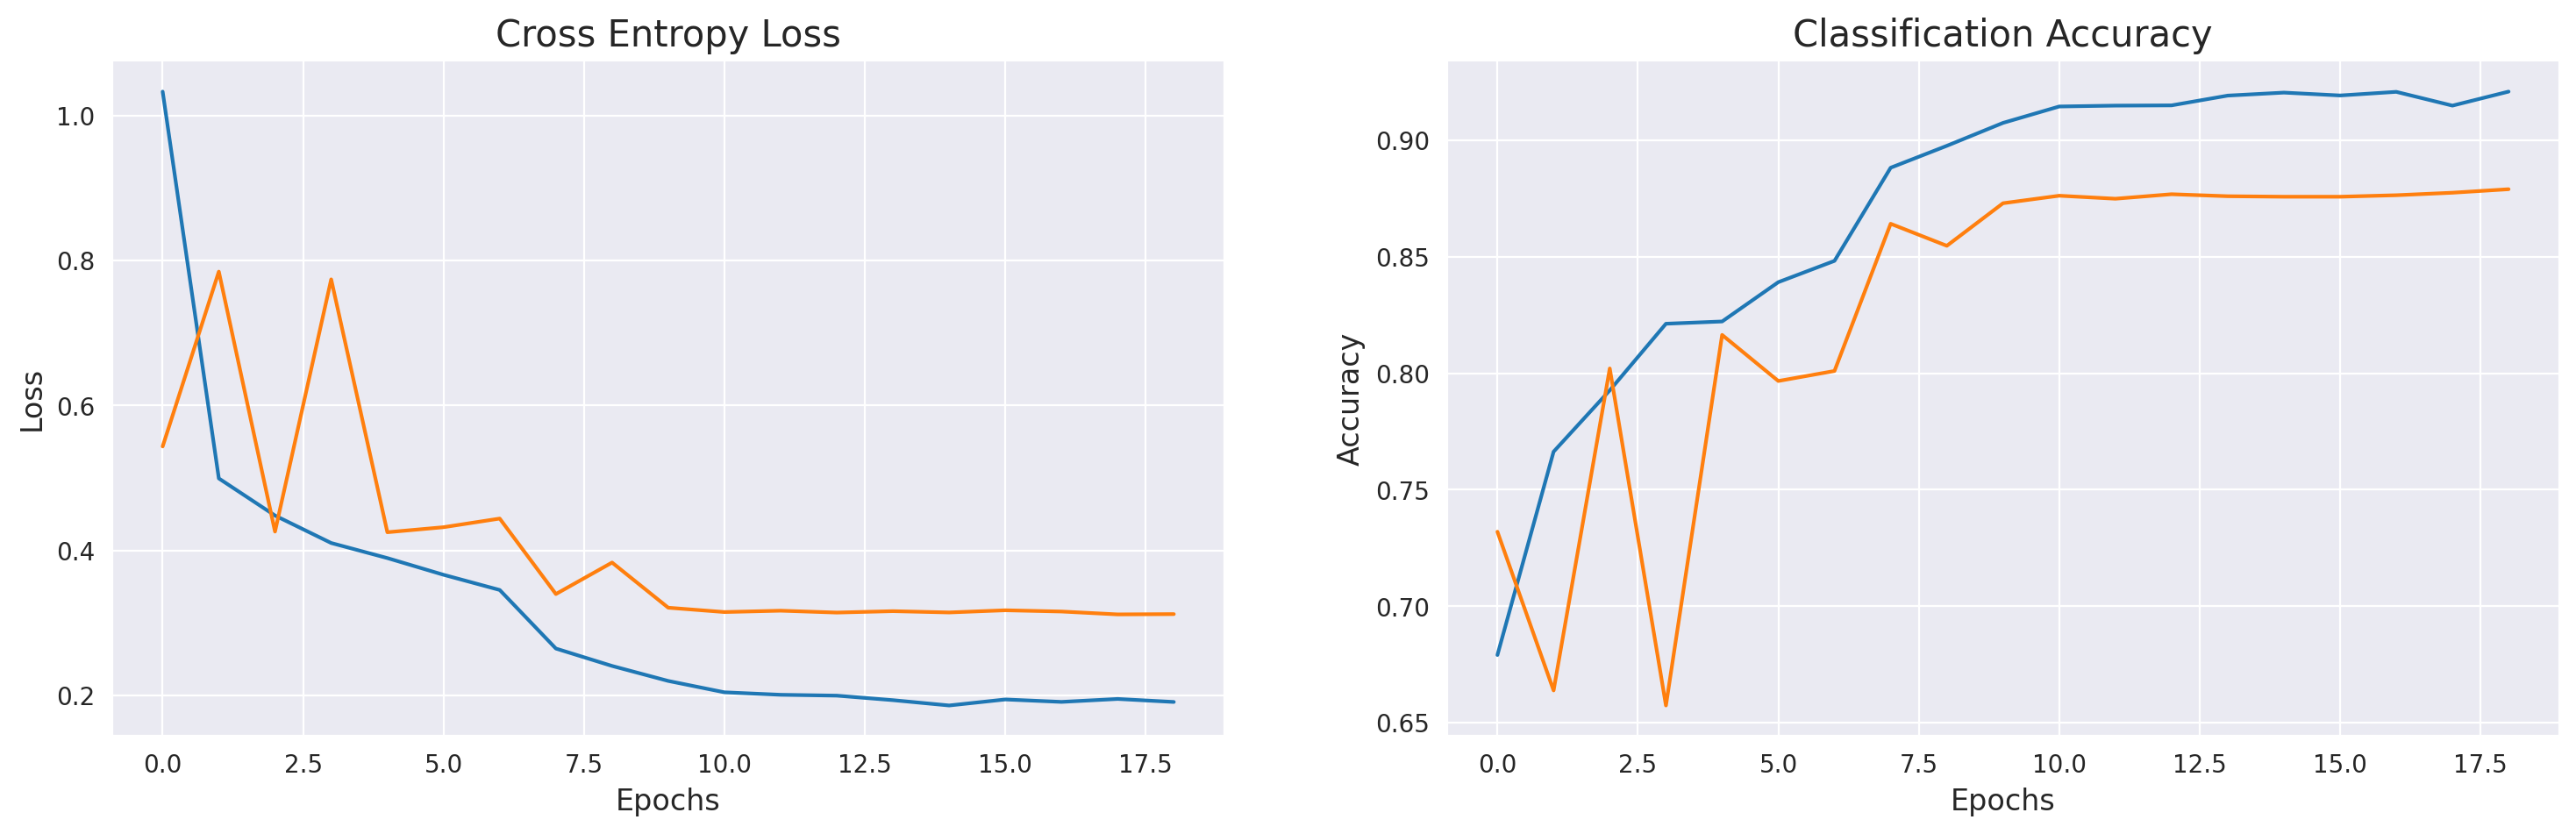

In [15]:


# plots for accuracy and Loss with epochs

error = pd.DataFrame(history.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()



In [17]:
preds = model.predict(train_dataset)
y_pred = np.argmax(preds, axis=1)  # Convert probabilities to class labels
print(y_pred)

582/582 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step
[0 0 1 ... 1 1 1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


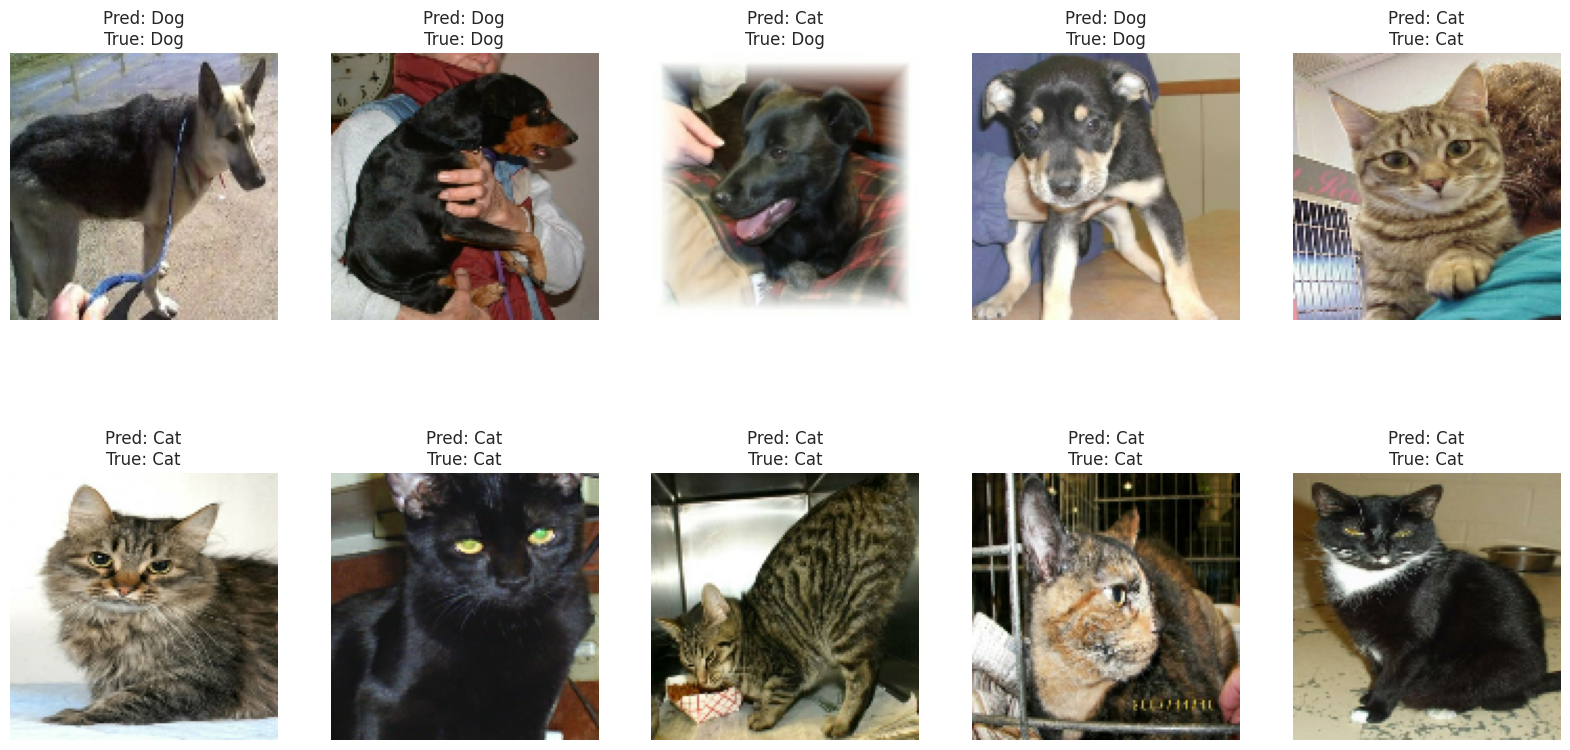

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = {0: "Cat", 1: "Dog"}

# Take one batch from the dataset
for images, labels in train_dataset.take(1):  # Take first batch
    preds = model.predict(images)             # Predict on batch
    y_pred = np.argmax(preds, axis=1)         # Convert probabilities to class labels
    y_true = np.argmax(labels.numpy(), axis=1)  # True labels

    num_images = min(len(images), 10)  # Limit to 10 images

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        img = images[i].numpy()  # Convert tensor to numpy array

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[y_pred[i]]}\nTrue: {class_names[y_true[i]]}", fontsize=12)
        plt.axis("off")
    plt.show()
    break  # Only need the first batch


In [22]:
test_score = model.evaluate(val_dataset)

146/146 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.8960 - loss: 0.2722


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

<Figure size 600x600 with 0 Axes>

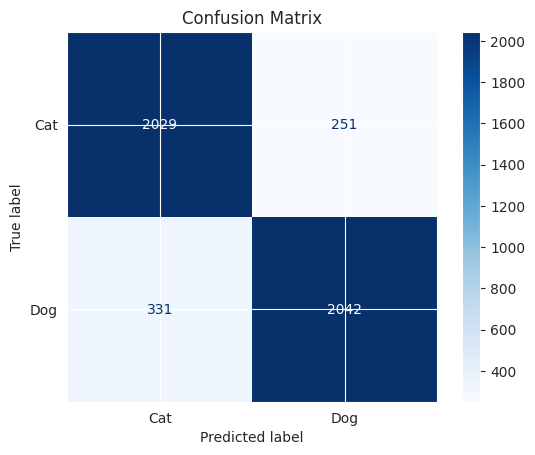

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect all predictions and true labels
y_preds = []
y_trues = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_preds.extend(np.argmax(preds, axis=1))
    y_trues.extend(np.argmax(labels.numpy(), axis=1))

y_preds = np.array(y_preds)
y_trues = np.array(y_trues)

# Compute confusion matrix
cm = confusion_matrix(y_trues, y_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Cat", "Dog"])

# Plot confusion matrix
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()
